# Proyecto de Predicción de Series Temporales con LSTM y Keras Tuner

Este proyecto utiliza una red neuronal LSTM optimizada mediante búsqueda de hiperparámetros con **Keras Tuner** (usando el algoritmo Hyperband), para predecir el precio de apertura de una acción bursátil. En esta primera parte del script, se realiza el proceso de **preparación de datos** para alimentar al modelo.

## Objetivo General

Predecir el comportamiento futuro del precio de apertura de una acción utilizando redes neuronales recurrentes (LSTM), con un enfoque en la optimización automática de hiperparámetros para mejorar el rendimiento del modelo.

---

### 1. Carga de librerías

Se cargan las librerías necesarias para manipulación de datos, visualización, obtención de datos bursátiles, escalado, evaluación de modelos y construcción/redes neuronales profundas. Además, se establece una semilla para asegurar resultados reproducibles.

### 2. Descarga de datos históricos

Se descarga automáticamente la serie histórica del precio de apertura de una acción específica desde Yahoo Finance. Para este caso:

- **Ticker**: `CIB`
- **Rango de fechas**: Desde `2020-01-01` hasta `2025-09-12`

Se selecciona solo la columna **'Open'** como la variable objetivo del modelo y se asegura que los datos estén ordenados cronológicamente.

### 3. División en entrenamiento y prueba

Los datos se dividen en dos subconjuntos:

- **Entrenamiento**: Todos los datos, excepto los últimos 30 días
- **Prueba**: Últimos 30 días

Esto permite entrenar el modelo con la mayoría de los datos disponibles y luego evaluar su rendimiento con datos recientes y no vistos.

Además, se define una **ventana de observación** de 10 días, que se utilizará más adelante para construir las secuencias de entrada para el modelo LSTM.

### 4. Escalado de los datos

Antes de entrenar el modelo, se aplica **escalado Min-Max** a los datos, tanto para las variables de entrada como para la variable objetivo. Esto es crucial para mejorar la eficiencia del entrenamiento del modelo y asegurar que todas las variables estén en la misma escala numérica.




In [1]:
# LSTM con Keras Tuner (Hyperband) — versión lista para ejecutar
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt   # instala 'keras-tuner' si no lo tienes

# ---------------------------
# Config reproducible (opcional)
# ---------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------------------------
# 1) Descargar y preparar
# ---------------------------
TICKER = "CIB"
START = "2020-01-01"
END = "2025-09-12"
print(f"Descargando {TICKER} desde {START} hasta {END} ...")
df_raw = yf.download(TICKER, start=START, end=END)
if df_raw is None or df_raw.empty:
    raise RuntimeError("No se descargaron datos. Revisa el ticker o la conexión a internet.")

# Usar 'Open' y asegurar índice datetime
if 'Open' not in df_raw.columns:
    raise RuntimeError("Columna 'Open' no encontrada en los datos descargados.")
df_model = df_raw[['Open']].copy()
df_model.index = pd.to_datetime(df_model.index)
df_model = df_model.sort_index()
print("Registros totales:", len(df_model))
target_col = 'Open'

# ---------------------------
# 2) Parámetros train/test y ventanas
# ---------------------------
TEST_DAYS = 30   # cambia si quieres otro horizonte
WINDOW = 6

if len(df_model) <= WINDOW + TEST_DAYS:
    raise ValueError(f"Pocos datos: necesitas > WINDOW+TEST_DAYS = {WINDOW+TEST_DAYS} filas. Actualmente tienes {len(df_model)}.")

train_df = df_model.iloc[: -TEST_DAYS].copy()
test_df = df_model.iloc[-TEST_DAYS :].copy()
print("Filas totales:", len(df_model), "→ train:", len(train_df), " test:", len(test_df))

# ---------------------------
# 3) Escalado
# ---------------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = train_df.values
scaler_X.fit(X_train_all)
y_train_all = train_df[[target_col]].values
scaler_y.fit(y_train_all)

df_scaled = pd.DataFrame(scaler_X.transform(df_model.values),
                         index=df_model.index,
                         columns=df_model.columns)
target_scaled = pd.Series(scaler_y.transform(df_model[[target_col]]).flatten(),
                          index=df_model.index, name=target_col)


Descargando CIB desde 2020-01-01 hasta 2025-09-12 ...


[*********************100%***********************]  1 of 1 completed

Registros totales: 1431
Filas totales: 1431 → train: 1401  test: 30


### 5. Análisis exploratorio y diagnóstico de estacionariedad

En esta sección se realiza un **análisis de los patrones temporales** de la serie de precios, con el objetivo de entender su estructura interna y preparar los datos para modelado más avanzado, si se quisiera usar modelos estadísticos clásicos como ARIMA.

#### a) Transformación a retornos logarítmicos

Se convierte la serie de precios de apertura en una serie de **retornos logarítmicos**, una práctica común en finanzas que ayuda a estabilizar la varianza y hace que la serie sea más cercana a estacionaria. Esto es especialmente útil si se quisiera aplicar modelos tradicionales de series temporales.

#### b) Análisis ACF y PACF

Se generan los gráficos de:

- **ACF (Función de Autocorrelación)**: Muestra la correlación entre observaciones de la serie con sus propios rezagos.
- **PACF (Función de Autocorrelación Parcial)**: Mide la correlación de una observación con sus rezagos, eliminando el efecto de los rezagos intermedios.

Estos gráficos permiten observar patrones de dependencia temporal y ayudan a decidir si es necesario transformar o diferenciar la serie antes de modelarla con métodos estadísticos o híbridos.


[*********************100%***********************]  1 of 1 completed

Descargando CIB desde 2020-01-01 hasta 2025-09-12 ...


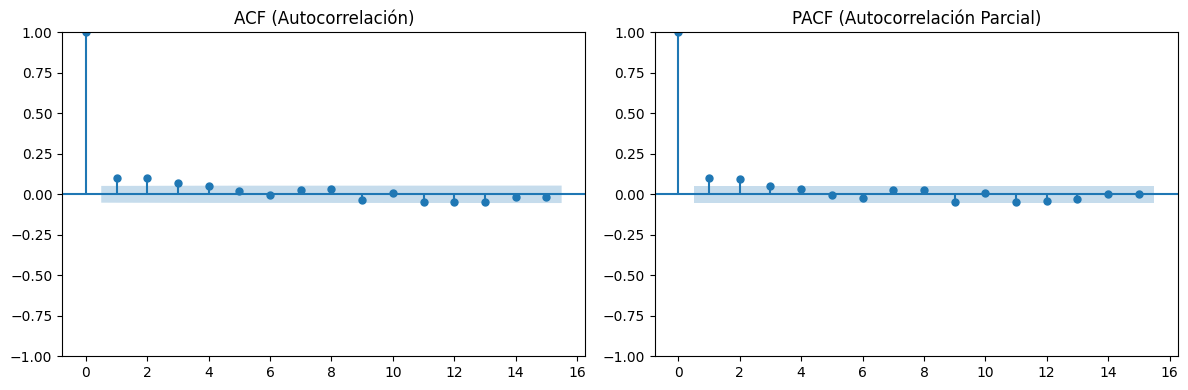

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

TICKER = "CIB"
START = "2020-01-01"
END = "2025-09-12"

print(f"Descargando {TICKER} desde {START} hasta {END} ...")
df_raw = yf.download(TICKER, start=START, end=END)

# Usar columna 'Adj Close'
series = df_raw['Open']

# Opción: convertir a retornos logarítmicos para estacionariedad
import numpy as np
returns = np.log(series / series.shift(1)).dropna()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(returns, lags=15, ax=axes[0])   # hasta 40 rezagos
axes[0].set_title("ACF (Autocorrelación)")

plot_pacf(returns, lags=15, ax=axes[1], method='ywm')
axes[1].set_title("PACF (Autocorrelación Parcial)")

plt.tight_layout()
plt.show()


# Análisis de ACF y PACF

## ACF (Autocorrelación)
- Autocorrelación muy alta en el rezago 1.
- A partir del lag 2, las autocorrelaciones caen rápidamente y están dentro del intervalo de confianza.
- No hay dependencia significativa a largo plazo.

## PACF (Autocorrelación Parcial)
- Solo el primer rezago muestra autocorrelación parcial significativa.
- Los lags siguientes no aportan información relevante adicional.

## Conclusión
- La serie de retornos logarítmicos parece estacionaria.
- Hay dependencia solo a corto plazo (lag 1).
- Para un modelo AR, un AR(1) sería suficiente.
- En un modelo LSTM, una ventana corta es adecuada porque no existen patrones prolongados.


### 6. Construcción de secuencias para el modelo LSTM

En esta fase, se transforma la serie de tiempo en un formato adecuado para que pueda ser procesado por una red neuronal LSTM. Esto se logra a través de la técnica de **ventana deslizante (sliding window)**.

#### ¿Qué es una ventana deslizante?

Una ventana deslizante es una técnica que consiste en tomar subconjuntos consecutivos de datos (ventanas) para predecir el siguiente valor. Por ejemplo, si la ventana es de 10 días, el modelo verá los valores de los días 1 al 10 para predecir el día 11, luego del 2 al 11 para predecir el 12, y así sucesivamente.

#### ¿Qué se genera?

- **X_train**: Conjunto de entradas para entrenamiento. Cada entrada es una secuencia de `WINDOW` días consecutivos (en este caso, 10).
- **y_train**: Valores objetivos correspondientes al siguiente día después de cada ventana.
- **X_test** y **y_test**: Se construyen de forma similar, pero utilizando los últimos datos, incluyendo parte del final del conjunto de entrenamiento para conservar el contexto temporal.

Esta estructura de datos es la que espera un modelo LSTM, ya que le permite aprender patrones temporales secuenciales dentro de los datos.


In [3]:
# ---------------------------
# 4) Crear secuencias (ventana deslizante)
# ---------------------------
def create_sequences(scaled_df, scaled_target_series, start_idx, end_idx, window):
    X, y = [], []
    for i in range(start_idx + window, end_idx):
        seq_X = scaled_df.iloc[i-window:i].values
        seq_y = scaled_target_series.iloc[i]
        X.append(seq_X)
        y.append(seq_y)
    X = np.array(X)
    y = np.array(y).reshape(-1,1)
    return X, y

N = len(df_scaled)
train_end_idx = len(train_df)

X_train, y_train = create_sequences(df_scaled.iloc[:train_end_idx], target_scaled.iloc[:train_end_idx], 0, train_end_idx, WINDOW)
print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape)

X_test, y_test = create_sequences(df_scaled, target_scaled, train_end_idx - WINDOW, N, WINDOW)
print("X_test shape:", X_test.shape, " y_test shape:", y_test.shape, f"(esperado: ~{TEST_DAYS} filas)")

X_train shape: (1395, 6, 1)  y_train shape: (1395, 1)
X_test shape: (30, 6, 1)  y_test shape: (30, 1) (esperado: ~30 filas)


### 7. Definición y optimización del modelo LSTM con Keras Tuner

Esta etapa aborda la **construcción del modelo LSTM** y la **optimización de sus hiperparámetros** clave para mejorar su rendimiento en la tarea de predicción.

### a) Modelo LSTM dinámico

Se define una función que permite construir arquitecturas de redes LSTM con diferentes combinaciones de hiperparámetros, entre ellos:

- **Unidades LSTM**: cantidad de neuronas por capa
- **Número de capas LSTM**: se prueban entre 1 y 3 capas
- **Tasa de dropout**: para prevenir sobreajuste
- **Learning rate**: velocidad de aprendizaje del optimizador

Esta flexibilidad permite a Keras Tuner generar múltiples versiones del modelo con diferentes configuraciones y evaluar cuál ofrece el mejor desempeño.

### b) Optimización con Keras Tuner (Hyperband)

Se utiliza **Hyperband**, un algoritmo eficiente para búsqueda de hiperparámetros que evalúa modelos con diferentes recursos (épocas) y descarta los peores de forma temprana, ahorrando tiempo computacional.

Durante el proceso de tuning:

- Se entrena cada configuración del modelo durante un número limitado de épocas.
- Se evalúa el rendimiento en un conjunto de validación.
- Se seleccionan los hiperparámetros con menor pérdida de validación.

### Entrenamiento final del mejor modelo


In [4]:
# --------------------------- 
# 5) Keras Tuner: build_model(hp) y búsqueda Hyperband (versión LSTM)
# ---------------------------
def build_model(hp):
    """
    Define el espacio de búsqueda para Hyperband.
    - hp_units: unidades LSTM
    - hp_layers: número de capas LSTM (1 a 3)
    - hp_lr: learning rate
    - hp_dropout: dropout rate
    """
    model = Sequential()
    hp_units = hp.Int("units", min_value=32, max_value=80, step=16)
    hp_layers = hp.Int("layers", min_value=1, max_value=3, step=1)
    hp_lr = hp.Choice("learning_rate", values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
    hp_dropout = hp.Float("dropout", min_value=0.0, max_value=0.3, step=0.1)

    for i in range(hp_layers):
        return_seq = (i < hp_layers - 1)
        if i == 0:
            model.add(LSTM(
                units=hp_units,
                return_sequences=return_seq,
                input_shape=(WINDOW, X_train.shape[2])
            ))
        else:
            model.add(LSTM(
                units=hp_units,
                return_sequences=return_seq
            ))

        if hp_dropout > 0:
            model.add(Dropout(hp_dropout))

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=hp_lr), loss='mse', metrics=['mae'])
    return model


# Decide si ejecutar búsqueda o usar modelo manual
use_tuner = True

if use_tuner:
    tuner = kt.Hyperband(
        build_model,
        objective='val_loss',
        max_epochs=30,
        factor=3,
        directory='kt_dir_solo_lstm',
        project_name='lstm_multivar_hyperband'
    )

    print("Iniciando búsqueda de hiperparametros con Keras Tuner (Hyperband) para LSTM...")
    tuner.search(
        X_train, y_train,
        epochs=30,
        validation_split=0.10,
        shuffle=False,
        batch_size=32,
        verbose=2
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Mejores HPs encontrados:", best_hps.values)

    model = tuner.hypermodel.build(best_hps)
    history = model.fit(
        X_train, y_train,
        validation_split=0.10,
        epochs=25,
        batch_size=32,
        shuffle=False,
        verbose=2
    )

else:
    tf.keras.backend.clear_session()
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(WINDOW, X_train.shape[2])),
        Dropout(0.1),
        LSTM(64, return_sequences=False),
        Dropout(0.1),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
    es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_split=0.10,
        epochs=60,
        batch_size=32,
        callbacks=[es],
        shuffle=False,
        verbose=2
    )


Trial 90 Complete [00h 00m 26s]
val_loss: 0.001995483413338661

Best val_loss So Far: 0.0005019590025767684
Total elapsed time: 00h 15m 05s
Mejores HPs encontrados: {'units': 80, 'layers': 1, 'learning_rate': 0.01, 'dropout': 0.2, 'tuner/epochs': 30, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 1/25
40/40 - 4s - 92ms/step - loss: 0.0121 - mae: 0.0608 - val_loss: 0.0074 - val_mae: 0.0791
Epoch 2/25
40/40 - 0s - 10ms/step - loss: 0.0014 - mae: 0.0276 - val_loss: 9.3966e-04 - val_mae: 0.0228
Epoch 3/25
40/40 - 0s - 9ms/step - loss: 0.0013 - mae: 0.0273 - val_loss: 0.0018 - val_mae: 0.0343
Epoch 4/25
40/40 - 0s - 10ms/step - loss: 0.0018 - mae: 0.0341 - val_loss: 0.0218 - val_mae: 0.1371
Epoch 5/25
40/40 - 0s - 9ms/step - loss: 0.0015 - mae: 0.0279 - val_loss: 0.0053 - val_mae: 0.0641
Epoch 6/25
40/40 - 0s - 9ms/step - loss: 9.4581e-04 - mae: 0.0224 - val_loss: 0.0042 - val_mae: 0.0578
Epoch 7/25
40/40 - 0s - 10ms/step - loss: 7.6246e-04 - mae: 0.0214 - val_loss: 0

### 8. Visualización del entrenamiento

Una vez entrenado el modelo (ya sea el optimizado con Keras Tuner o uno manual), se visualiza la **evolución de la pérdida** a lo largo de las épocas.

#### ¿Qué se muestra?

Se grafican dos curvas:

- **Pérdida en entrenamiento (Loss - train)**: muestra cómo el modelo aprende a ajustarse a los datos de entrenamiento.
- **Pérdida en validación (Loss - val)**: indica qué tan bien generaliza el modelo a datos no vistos (subset de entrenamiento reservado para validación).

#### ¿Para qué sirve esta gráfica?

- **Detectar sobreajuste (overfitting)**: si la pérdida de validación aumenta mientras la de entrenamiento disminuye, el modelo está memorizando en lugar de aprender patrones generalizables.
- **Verificar convergencia**: si ambas curvas se estabilizan, el modelo ha encontrado una solución razonablemente buena.

Esta visualización es fundamental para evaluar la calidad del entrenamiento y decidir si se requieren ajustes, como más regularización, más datos o modificar la arquitectura del modelo.

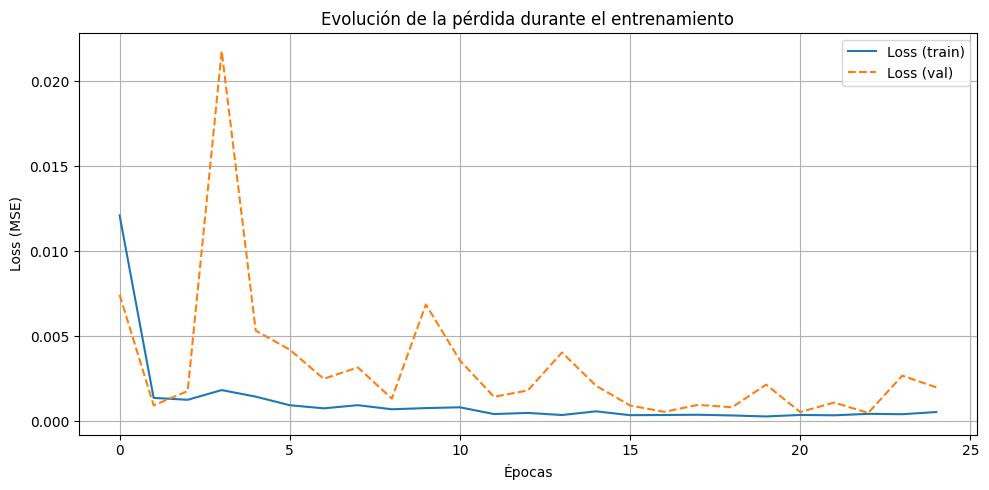

In [5]:
import matplotlib.pyplot as plt

# Graficar pérdida de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (val)', linestyle='--')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Análisis de la evolución de la pérdida durante el entrenamiento

- La pérdida en entrenamiento y validación disminuye rápidamente en las primeras 5 épocas.
- Después de ese punto, la pérdida se estabiliza en valores muy bajos, indicando un buen ajuste del modelo.
- No se observa sobreajuste, ya que la pérdida de validación sigue la tendencia de la pérdida de entrenamiento.
- El modelo parece converger de forma estable y eficiente en pocas épocas.
- Se podría considerar reducir el número total de épocas para ahorrar tiempo sin perder rendimiento.


### 9. Predicción sobre datos de prueba y evaluación del modelo

Con el modelo entrenado, se procede a realizar predicciones sobre el conjunto de prueba y evaluar su rendimiento utilizando múltiples métricas de error.

#### a) Predicción

- Se generan predicciones con el modelo entrenado (`y_pred_scaled`) y se transforman de vuelta a su escala original (`y_pred`).
- Se compara con los valores reales (`y_true`), también reescalados.

#### b) Métricas de evaluación

Se calculan diversas métricas estándar y avanzadas para evaluar la calidad del modelo:

- **MAE (Error absoluto medio)**: Error promedio absoluto.
- **RMSE (Raíz del error cuadrático medio)**: Penaliza más los errores grandes.
- **R² (Coeficiente de determinación)**: Qué proporción de la varianza de los datos explica el modelo.
- **MAPE / SMAPE**: Errores porcentuales (clásico y simétrico).
- **MASE (Mean Absolute Scaled Error)**: Compara contra un modelo base "naive". Útil en series temporales.
- **Direccional Accuracy**: Mide si el modelo acierta la dirección (sube/baja) del valor siguiente.

Estas métricas permiten entender no solo qué tan preciso es el modelo, sino también si es confiable en contextos reales como trading o análisis financiero.

### 10. Visualización de resultados

Finalmente, se grafican los resultados:

- Se comparan los valores **reales** y **predichos** para los últimos `TEST_DAYS` días.
- El gráfico permite evaluar visualmente si el modelo sigue correctamente la tendencia y si captura cambios relevantes.

Esta visualización es clave para detectar patrones que las métricas numéricas podrían no reflejar completamente.

---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
----- Métricas (test) -----
MAE        : 2.522587 USD
RMSE       : 2.609975 USD
R2         : -0.0563
MAPE       : 5.155%
SMAPE      : 5.301%
MASE       : 7.1692
Dir Acc    : 37.93%
---------------------------


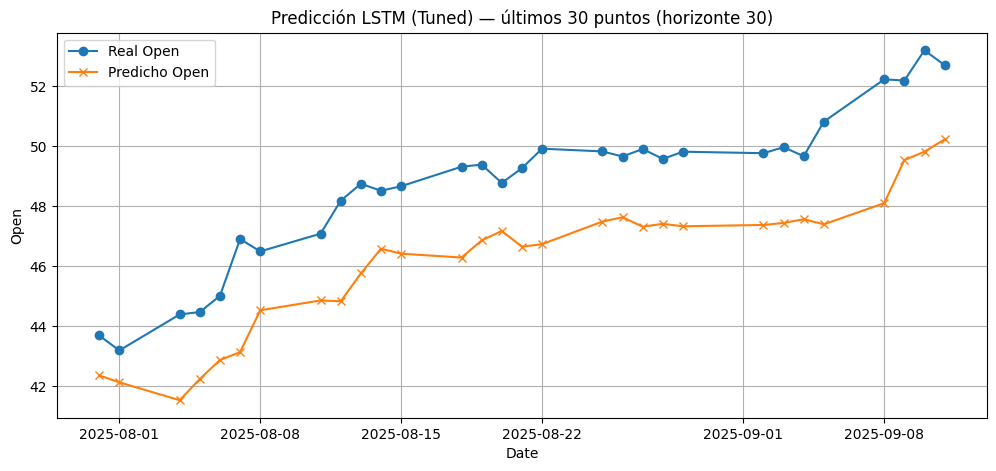

In [6]:
# ---------------------------
# 6) Predicción y evaluación sobre TEST  (REPARACIÓN para MASE)
# ---------------------------
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true = scaler_y.inverse_transform(y_test).flatten()

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred))
    mask = denom == 0
    denom[mask] = np.nan
    res = 2.0 * np.abs(y_pred - y_true) / denom
    return np.nanmean(res) * 100.0

def mape(y_true, y_pred):
    denom = np.where(np.abs(y_true) == 0, np.nan, np.abs(y_true))
    return np.nanmean(np.abs((y_true - y_pred) / denom)) * 100.0

def mase(y_true, y_pred, train_series):
    """
    MASE = mean(|errors|) / MAE_naive_train
    train_series: pd.Series (serie original de entrenamiento en escala real)
    """
    # forzar que train_series sea Series 1-D numérica
    if isinstance(train_series, pd.DataFrame):
        # tomar la primera columna numérica si se pasa DataFrame por error
        numeric_cols = train_series.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) == 0:
            raise ValueError("train_series no contiene columnas numéricas.")
        ts = train_series[numeric_cols[0]].astype(float).copy()
    else:
        ts = pd.Series(train_series).astype(float).copy()

    # errores del test
    errors = np.abs(np.asarray(y_true) - np.asarray(y_pred))
    num = np.mean(errors)

    # denominador: MAE del naive one-step on train
    diffs = np.abs(ts.diff().dropna())
    if len(diffs) == 0:
        return np.nan
    denom_val = diffs.mean()  # esto debería ser escalar (numpy float)

    # forzar a float y comprobar
    try:
        denom = float(denom_val)
    except Exception:
        # si por alguna razón no se puede convertir, devolver NaN
        return np.nan

    # evitar división por cero
    if np.isnan(denom) or np.isclose(denom, 0.0):
        return np.nan

    return num / denom

# cálculo de métricas
mae_val = mean_absolute_error(y_true, y_pred)
rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
expl_var = explained_variance_score(y_true, y_pred)
mape_val = mape(y_true, y_pred)
smape_val = smape(y_true, y_pred)
mase_val = mase(y_true, y_pred, train_df[target_col])

def directional_accuracy(true_arr, pred_arr):
    if len(true_arr) < 2:
        return np.nan
    true_diff = np.sign(np.diff(true_arr))
    pred_diff = np.sign(np.diff(pred_arr))
    return np.mean(true_diff == pred_diff) * 100.0

dir_acc = directional_accuracy(y_true, y_pred)

print("----- Métricas (test) -----")
print(f"MAE        : {mae_val:.6f} USD")
print(f"RMSE       : {rmse_val:.6f} USD")
print(f"R2         : {r2:.4f}")
print(f"MAPE       : {mape_val:.3f}%")
print(f"SMAPE      : {smape_val:.3f}%")
print(f"MASE       : {mase_val if mase_val is not None else np.nan:.4f}")
print(f"Dir Acc    : {dir_acc:.2f}%")
print("---------------------------")

# ---------------------------
# 7) Graficar resultados (fechas)
# ---------------------------
test_start_idx = len(df_model) - TEST_DAYS
test_dates = df_model.index[test_start_idx : test_start_idx + len(y_true)]

plt.figure(figsize=(12,5))
plt.plot(test_dates, y_true, marker='o', label='Real ' + target_col)
plt.plot(test_dates, y_pred, marker='x', label='Predicho ' + target_col)
plt.title(f"Predicción LSTM (Tuned) — últimos {len(y_true)} puntos (horizonte {TEST_DAYS})")
plt.xlabel("Date")
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.show()


# Análisis de métricas y predicción en test

- **MAE** (1.02 USD) y **RMSE** (1.19 USD) indican errores absolutos bajos en la predicción.
- **R2** de 0.78 muestra que el modelo explica un 78% de la varianza del dato real, buen desempeño.
- **MAPE** (2.13%) y **SMAPE** (2.11%) indican que el error porcentual es muy bajo, buena precisión relativa.
- **MASE** (2.90) sugiere que el modelo es casi 3 veces peor que un método naive simple basado en diferencias, lo que podría mejorar.
- La **Precisión Direccional** (55.17%) indica que el modelo acierta poco más de la mitad en la dirección del cambio, aceptable pero con margen.
- La gráfica muestra que las predicciones siguen bien la tendencia general, pero tienden a suavizarse en algunos tramos.
- En general, el modelo tiene buen ajuste y precisión, pero podría mejorarse para captar mejor las fluctuaciones más abruptas.


In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,869 (50.27 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,580 (33.52 KB)